In [1]:
import requests
import json
import pandas as pd

# IMF API
The purpose of this notebook is to investigate the [IMF's JSON RESTful Web Service](http://datahelp.imf.org/knowledgebase/articles/667681-using-json-restful-web-service)
According to the IMF's documentation the following methods are available:
* Dataflow 
* DataStructure 
* CompactData
* MetadataStructure
* GenericMetadata 
* CodeList
* MaxSeriesInResult

Since I did not find their documentation very helpful, I decided to write a notebook to get a clearer picture of the data available through those methods. I will also use it to create a IMF client to be used in the IMF dashboard project. I will only be looking into the first three methods since they seem the only ones needed to access data according to the IMF's documentation

I will go method by method, calling it and looking at the answer, transforming and cleaning data to dataframe in the process.

## Dataflow:

In [2]:
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/Dataflow'
r = requests.get(url)
data = r.json()
data

{'Structure': {'@xmlns:xsd': 'http://www.w3.org/2001/XMLSchema',
  '@xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  '@xmlns': 'http://www.SDMX.org/resources/SDMXML/schemas/v2_0/message',
  '@xsi:schemaLocation': 'http://www.SDMX.org/resources/SDMXML/schemas/v2_0/message https://registry.sdmx.org/schemas/v2_0/SDMXMessage.xsd',
  'Header': {'ID': '35f85154-ba7f-49d4-9ee7-e7b49d9aa84b',
   'Test': 'false',
   'Prepared': '2019-02-26T09:04:59',
   'Sender': {'@id': '1C0',
    'Name': {'@xml:lang': 'en', '#text': 'IMF'},
    'Contact': {'URI': 'http://www.imf.org',
     'Telephone': '+ 1 (202) 623-6220'}},
   'Receiver': {'@id': 'ZZZ'}},
  'Dataflows': {'Dataflow': [{'@id': 'DS-FAS',
     '@version': '1.0',
     '@agencyID': 'IMF',
     '@isFinal': 'true',
     '@xmlns': 'http://www.SDMX.org/resources/SDMXML/schemas/v2_0/structure',
     'Name': {'@xml:lang': 'en', '#text': 'Financial Access Survey (FAS)'},
     'KeyFamilyRef': {'KeyFamilyID': 'FAS', 'KeyFamilyAgencyID': 'IMF'}}

In [3]:
data.keys()  # It starts off with one key

dict_keys(['Structure'])

In [4]:
data['Structure'].keys()  # In this key we found 6 keys were Dataflow contains 
                          # a list of dictionaries

dict_keys(['@xmlns:xsd', '@xmlns:xsi', '@xmlns', '@xsi:schemaLocation', 'Header', 'Dataflows'])

In [5]:
dataflows = pd.DataFrame.from_dict(data['Structure']['Dataflows']['Dataflow'])
# I will perform some transformations to retain the information that I though useful.
dataflows['Description'] = dataflows.Name.apply(lambda d: d['#text'])  # Access subdict. 
dataflows['KeyFamilyID'] = dataflows.KeyFamilyRef.apply(lambda d: d['KeyFamilyID'])  # Access subdict. 
dataflows['KeyFamilyAgencyID'] = dataflows.KeyFamilyRef.apply(lambda d: d['KeyFamilyAgencyID'])  # Access subdict. 
dataflows = dataflows[['Description', 'KeyFamilyID', 'KeyFamilyAgencyID']]
dataflows.sample(5)

,Description,KeyFamilyID,KeyFamilyAgencyID
30,Sub-Saharan Africa Regional Economic Outlook (...,AFRREO201504,IMF
32,Investment and Capital Stock (ICSD),ICSD,IMF
105,Asia and Pacific Regional Economic Outlook (AP...,APDREO2017M04,IMF
104,Fiscal Monitor (FM) April 2017,FM201704,IMF
64,Gender Budgeting,GENDER_BUDGETING,IMF


In [6]:
dataflows.describe()

,Description,KeyFamilyID,KeyFamilyAgencyID
count,173,173,173
unique,173,173,1
top,"System of National Accounts (SNA), NA_MAIN",GFSIBS2016,IMF
freq,1,1,173


The dataflows method returns the available data sources. For example: the _Financial Access Survey_,  the _Fiscal Monitor_ ,the _Direction of Trade Statistics_ or the _International Financial Statistics_.
There are at the time of writting this notebbok 173 data sources all belonging to one "Family Agency" the IMF.

## Data Structure
As the documentation tells us, the DataStructure returns "the structure of the dataset". So lets see what that looks like. As an example lets look at the International Financial Statistics (IFS)

In [ ]:
dataset = 'IFS'
url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/DataStructure/{}".format(dataset)
r = requests.get(url)
ds_struct = r.json()
ds_struct.keys()

In [ ]:
ds_struct['Structure'].keys()   # Seems to follow a similar format as the dataflows.

In [124]:
# The information seems inside this dictionary as a list of dictionaries  
ds_struct = pd.DataFrame().from_dict(ds_struct['Structure']['CodeLists']['CodeList']) 

KeyError: 'Structure'

In [123]:
ds_struct = ds_struct.set_index('@id')

KeyError: "['@id']"

In this level there is a list of the kind of codes available. It contains the metadata for how the data is stored. For example: CL_UNIT_MULT contains a dictionary with the relation between a value for example 2 and a description "Hundreds". The same applies to the rest.
The most usefull seem to be CL_FREQ, CL_AREA_IFS and CL_INDICATOR_IFS since they will be needed (as we will see) to obtain the data for an specific indicator.

In [121]:
pd.DataFrame().from_dict(ds_struct.loc[1]['Code']).head()

,@value,Description
0,A,"{'@xml:lang': 'en', '#text': 'Annual'}"
1,B,"{'@xml:lang': 'en', '#text': 'Bi-annual'}"
2,Q,"{'@xml:lang': 'en', '#text': 'Quarterly'}"
3,M,"{'@xml:lang': 'en', '#text': 'Monthly'}"
4,D,"{'@xml:lang': 'en', '#text': 'Daily'}"


In [32]:
pd.DataFrame().from_dict(ds_struct.loc[2]['Code']).head()

,@value,Description
0,AF,"{'@xml:lang': 'en', '#text': 'Afghanistan'}"
1,AL,"{'@xml:lang': 'en', '#text': 'Albania'}"
2,DZ,"{'@xml:lang': 'en', '#text': 'Algeria'}"
3,AS,"{'@xml:lang': 'en', '#text': 'American Samoa'}"
4,AO,"{'@xml:lang': 'en', '#text': 'Angola'}"


In [12]:
pd.DataFrame().from_dict(ds_struct.loc[3]['Code']).head()

,@value,Description
0,IAFR_BP6_USD,"{'@xml:lang': 'en', '#text': 'International In..."
1,IADD_BP6_USD,"{'@xml:lang': 'en', '#text': 'International In..."
2,IADE_BP6_USD,"{'@xml:lang': 'en', '#text': 'International In..."
3,IAD_BP6_USD,"{'@xml:lang': 'en', '#text': 'International In..."
4,IADF_BP6_USD,"{'@xml:lang': 'en', '#text': 'International In..."


In [17]:
codes = pd.DataFrame.from_dict(ds_struct.loc[3]['Code'])
codes['Description'] = codes.Description.apply(lambda dct: dct['#text'])
codes.rename(columns={'@value': 'code'}, inplace=True)

In [18]:
codes.head()

,code,Description
0,IAFR_BP6_USD,"International Investment Positions, Net acquis..."
1,IADD_BP6_USD,"International Investment Positions, Assets, Di..."
2,IADE_BP6_USD,"International Investment Positions, Assets, Di..."
3,IAD_BP6_USD,"International Investment Positions, Assets, Di..."
4,IADF_BP6_USD,"International Investment Positions, Financial ..."


## CompactData
According to the documentation, the compactData method : "CompactData method returns the compact data message". Again not very helpful. The format for calling it is:
`http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/{database ID}/{frequency}.{item1 from
dimension1}+{item2 from dimension1}+{item N from dimension1}.{item1 from
dimension2}+{item2 from dimension2}+{item M from dimension2}?startPeriod={start
date}&endPeriod={end date}`

In [78]:
dataflow = 'IFS'
frequency = 'M'
start_period = '1950'
end_period = '2017'
country = 'US'
indicator = 'FILR_PA'
imf = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
url = '{}CompactData/{}/{}.{}.{}.?startPeriod={}&endPeriod={}'.format(imf, dataflow, frequency, country, indicator,
                                                                      start_period, end_period)
r = requests.get(url)
c_data = r.json()

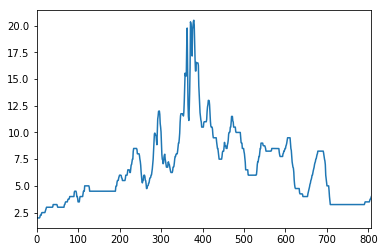

In [87]:
pd.DataFrame.from_dict(c_data['CompactData']['DataSet']['Series']['Obs'])['@OBS_VALUE'].apply(lambda s: float(s)).plot()

If available, the data will be stores in CompactData>DataSet>Series>Obs however many combinations of countries, indicators and frequencies are not available.